In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from careamics.lightning.dataset_ng.data_module import CareamicsDataModule
from careamics.config.configuration_factories import create_n2v_configuration

In [117]:
# issues: random seed not fixed for validation
# no checks that mean and std are set
# np digitize slows up the pipeline
# how to apply padding in case of the full image

In [19]:
from pathlib import Path

import tifffile
import numpy as np
import matplotlib.pyplot as plt

from careamics_portfolio import PortfolioManager

# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_BSD68.download(root_path)

# create paths for the data
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

In [20]:
image_std, image_mean = [], [] 
for file in train_path.glob("*.tiff"):
    image = tifffile.imread(file)
    image_std.append(image.std())
    image_mean.append(image.mean())
image_std, image_mean = np.mean(image_std), np.mean(image_mean)

{'shuffle': False}


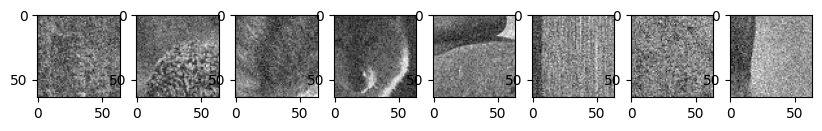

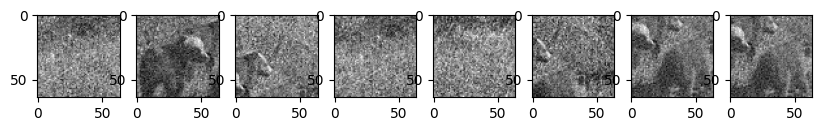

In [118]:
# from path, train and val, no target

config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=100
)

config.data_config.set_means_and_stds([image_mean], [image_std])
config.data_config.val_dataloader_params = {"shuffle": False}

data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=train_path,
    val_data=val_path,
)
data_module.setup('fit')
data_module.setup('validate')

train_batch = next(iter(data_module.train_dataloader()))
val_batch = next(iter(data_module.val_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(train_batch[0].data[i][0].numpy(), cmap="gray")


fig, ax = plt.subplots(1, 8, figsize=(10, 5))
for i in range(8):
    ax[i].imshow(val_batch[0].data[i][0].numpy(), cmap="gray")

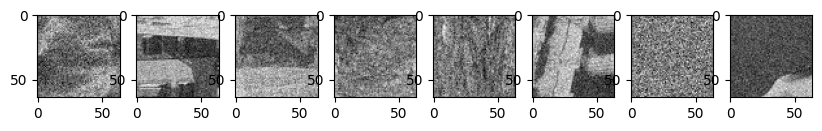

In [121]:
# from path, only train

config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=100
)

config.data_config.set_means_and_stds([image_mean], [image_std])
config.data_config.val_dataloader_params = {"shuffle": False}

data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=train_path
)
data_module.setup('fit')

train_batch = next(iter(data_module.train_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(train_batch[0].data[i][0].numpy(), cmap="gray")


{'shuffle': False}


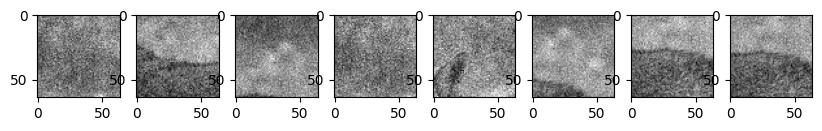

In [124]:
# from path, only val

config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=100
)

config.data_config.set_means_and_stds([image_mean], [image_std])
config.data_config.val_dataloader_params = {"shuffle": False}

data_module = CareamicsDataModule(
    data_config=config.data_config,
    val_data=train_path
)
data_module.setup('validate')

val_batch = next(iter(data_module.val_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(val_batch[0].data[i][0].numpy(), cmap="gray")


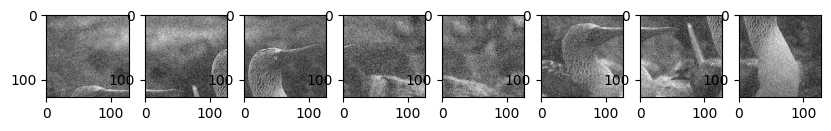

In [133]:
# from path, only predict

from careamics.config.inference_model import InferenceConfig

config = InferenceConfig(
    model_config=config,
    data_type="tiff",
    tile_size=(128, 128),
    tile_overlap=(32, 32),
    axes="YX",
    batch_size=8,
    image_means=[image_mean],
    image_stds=[image_std]
)

data_module = CareamicsDataModule(
    data_config=config,
    predict_data=test_path
)
data_module.setup('predict')

pred_batch = next(iter(data_module.predict_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(pred_batch[0].data[i][0].numpy(), cmap="gray")

In [ ]:
# test from array

In [134]:
train_array = tifffile.imread(sorted(train_path.rglob('*'))[0])
val_array = tifffile.imread(sorted(val_path.rglob('*'))[0])
test_array = tifffile.imread(sorted(test_path.rglob('*'))[0])

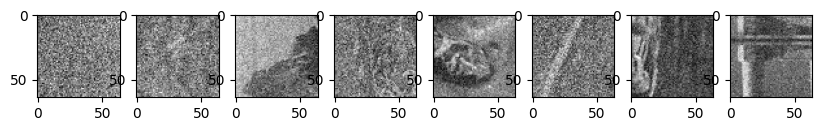

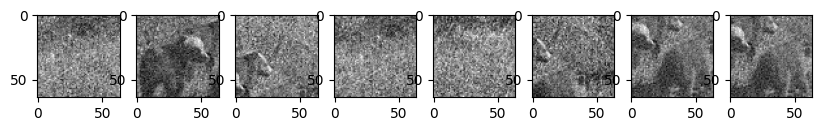

In [154]:
# from array, train and val, no target

config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=100
)

config.data_config.set_means_and_stds([image_mean], [image_std])
config.data_config.val_dataloader_params = {"shuffle": False}

data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=train_array,
    val_data=val_array,
)
data_module.setup('fit')
data_module.setup('validate')

train_batch = next(iter(data_module.train_dataloader()))
val_batch = next(iter(data_module.val_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(train_batch[0].data[i][0].numpy(), cmap="gray")


fig, ax = plt.subplots(1, 8, figsize=(10, 5))
for i in range(8):
    ax[i].imshow(val_batch[0].data[i][0].numpy(), cmap="gray")

In [135]:
# test with target

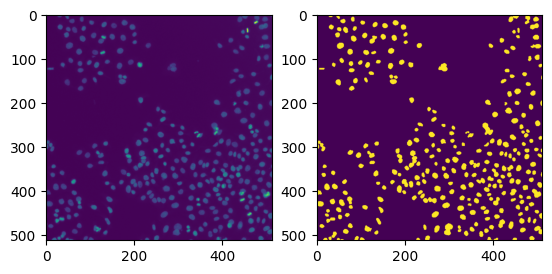

In [155]:
import skimage

example_data = skimage.data.human_mitosis()

markers = np.zeros_like(example_data)
markers[example_data < 25] = 1
markers[example_data > 50] = 2

elevation_map = skimage.filters.sobel(example_data)
segmentation = skimage.segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(example_data)
ax[1].imshow(segmentation)
plt.show()

In [163]:
example_data.shape, segmentation.shape

((512, 512), (512, 512))

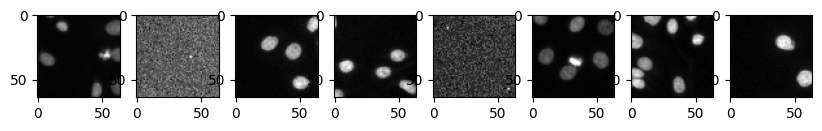

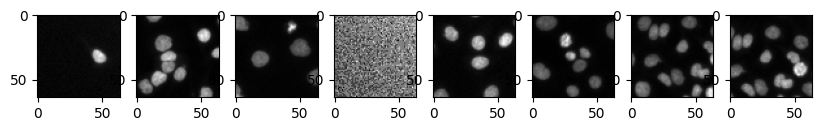

In [180]:
config = create_n2v_configuration(
    experiment_name="mitosis",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=100
)
config.data_config.set_means_and_stds([example_data.mean()], [example_data.std()])

data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=example_data,
    train_data_target=segmentation,
    val_data=example_data,
    val_data_target=segmentation
)
data_module.setup('fit')
data_module.setup('validate')

train_batch = next(iter(data_module.train_dataloader()))
val_batch = next(iter(data_module.val_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(train_batch[0].data[i][0].numpy(), cmap="gray")


fig, ax = plt.subplots(1, 8, figsize=(10, 5))
for i in range(8):
    ax[i].imshow(val_batch[0].data[i][0].numpy(), cmap="gray")

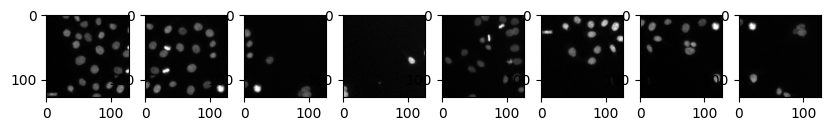

In [189]:
# from array, only predict, with target

from careamics.config.inference_model import InferenceConfig

config = InferenceConfig(
    model_config=config,
    data_type="array",
    tile_size=(128, 128),
    tile_overlap=(32, 32),
    axes="YX",
    batch_size=8,
    image_means=[image_mean],
    image_stds=[image_std]
)

data_module = CareamicsDataModule(
    data_config=config,
    predict_data=example_data,
    predict_data_target=segmentation
)
data_module.setup('predict')

pred_batch = next(iter(data_module.predict_dataloader()))

fig, ax = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    ax[i].imshow(pred_batch[0].data[i][0].numpy(), cmap="gray")